In [1]:
! pip install transformers

In [2]:
! pip install datasets

In [3]:
pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import sys
import numpy as np

import pandas as pd
import transformers
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
import shutil
import sys

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
from IPython import display
%matplotlib widget
%matplotlib inline
import shutil
import sys

### Осмотр датасета

Сначала загрузим датасет и посмотрим на него, что в нём есть, что мы можем из него использовать и тд.

In [6]:
datasets = load_dataset('AmazonScience/massive', 'en-US')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset massive downloaded and prepared to /root/.cache/huggingface/datasets/AmazonScience___massive/en-US/1.0.0/71d360eb7d7a18565ff8c10609cebf714fce3cc390e173ba5b02ffd48543cdc1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2974
    })
})

In [8]:
datasets['train'][0]

{'id': '1',
 'locale': 'en-US',
 'partition': 'train',
 'scenario': 16,
 'intent': 48,
 'utt': 'wake me up at nine am on friday',
 'annot_utt': 'wake me up at [time : nine am] on [date : friday]',
 'worker_id': '1',
 'slot_method': {'slot': [], 'method': []},
 'judgments': {'worker_id': [],
  'intent_score': [],
  'slots_score': [],
  'grammar_score': [],
  'spelling_score': [],
  'language_identification': []}}

In [9]:
import random

In [10]:
for i in range(10):
    print(datasets['train'][random.randint(0, 11514)]['utt'])

read me the content of this list
change my house lights color to blue
what food is good
please wake me up at seven thirty am
did i forget anything
do i have any appointments this weekend
should i plan to shovel my way out of the house
what kind of lists do i have
add build my resume to my to do list
what hour of the day is it in dallas


In [11]:
train, val, test = pd.DataFrame(datasets['train']), pd.DataFrame(datasets['validation']), pd.DataFrame(datasets['test'])

In [12]:
train.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments
0,1,en-US,train,16,48,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
1,2,en-US,train,16,48,set an alarm for two hours from now,set an alarm for [time : two hours from now],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
2,4,en-US,train,10,46,olly quiet,olly quiet,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
3,5,en-US,train,10,46,stop,stop,1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."
4,6,en-US,train,10,46,olly pause for ten seconds,olly pause for [time : ten seconds],1,"{'slot': [], 'method': []}","{'worker_id': [], 'intent_score': [], 'slots_s..."


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11514 entries, 0 to 11513
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           11514 non-null  object
 1   locale       11514 non-null  object
 2   partition    11514 non-null  object
 3   scenario     11514 non-null  int64 
 4   intent       11514 non-null  int64 
 5   utt          11514 non-null  object
 6   annot_utt    11514 non-null  object
 7   worker_id    11514 non-null  object
 8   slot_method  11514 non-null  object
 9   judgments    11514 non-null  object
dtypes: int64(2), object(8)
memory usage: 899.7+ KB


In [14]:
train.describe()

,scenario,intent
count,11514.000000,11514.000000
mean,7.270801,31.234758
std,4.968271,17.150613
min,0.000000,0.000000
25%,3.000000,15.000000
50%,7.000000,32.000000
75%,12.000000,47.000000
max,17.000000,59.000000


Мы видим, что у нас всего 60 интентов, следовательно и классов тоже 60

Нетрудно заметить, что для данного задания нам нужны 2 столбца :"intent", "utt". "annot_utt" это обработанный запрос, однако не было запрета на его использование,"annot_utt" сильно предобработан, поэтому уберем его тоже, так как на реальных данных у нас будет только текст

In [15]:
train.drop(['id', 'locale', 'partition', 'scenario', 'worker_id', 'slot_method', 'judgments', 'annot_utt'], axis=1, inplace=True)
test.drop(['id','locale', 'partition', 'scenario', 'worker_id', 'slot_method', 'judgments','annot_utt'], axis=1, inplace=True)
val.drop(['id','locale', 'partition', 'scenario', 'worker_id', 'slot_method', 'judgments', 'annot_utt'], axis=1, inplace=True)

In [16]:
train

,intent,utt
0,48,wake me up at nine am on friday
1,48,set an alarm for two hours from now
2,46,olly quiet
3,46,stop
4,46,olly pause for ten seconds
...,...,...
11509,17,send hi in watsapp to vikki
11510,44,do i have emails
11511,44,what emails are new
11512,44,do i have new emails from john


In [17]:
test

,intent,utt
0,48,wake me up at five am this week
1,46,quiet
2,1,pink is all we need
3,41,and the darkness has fallen
4,40,olly turn the lights off in the bedroom
...,...,...
2969,33,my friend john has sent me a invitation card t...
2970,44,check my email for any new email from joe
2971,44,do i have any new email from joe
2972,44,notify me when joshua emails me


In [18]:
val

,intent,utt
0,40,turn the lights off please
1,31,dim the lights in the hall
2,31,make a room darker
3,34,clean the flat
4,34,cleaning is good dust is so bad do now your ma...
...,...,...
2028,44,report any new emails
2029,44,how many unread messages have i got
2030,33,please respond to the email i just read
2031,44,did bert write me today


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11514 entries, 0 to 11513
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   intent  11514 non-null  int64 
 1   utt     11514 non-null  object
dtypes: int64(1), object(1)
memory usage: 180.0+ KB


In [20]:
train.describe()

,intent
count,11514.000000
mean,31.234758
std,17.150613
min,0.000000
25%,15.000000
50%,32.000000
75%,47.000000
max,59.000000


Мат ожидание и дисперсия нам говорят, что классов довольно много, надо будет посмотреть как они распределены. Сбалансированны ли они, например

/tmp/ipykernel_29/3244310550.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['intent'])


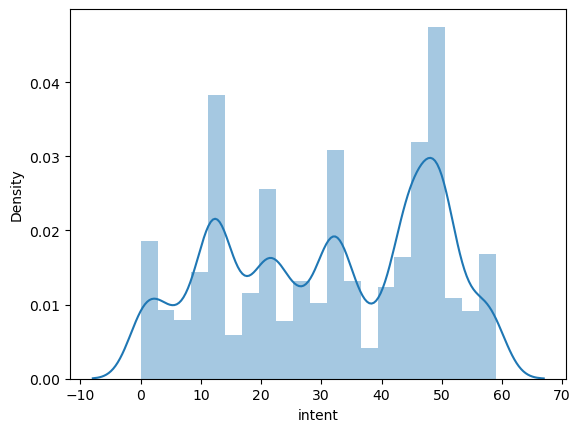

In [21]:
sns.distplot(train['intent'])
plt.show()

Посмотрим на распределения трейна и теста, трейна и валидационной выборки

/tmp/ipykernel_29/1769239804.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['intent'])
/tmp/ipykernel_29/1769239804.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test['intent'])


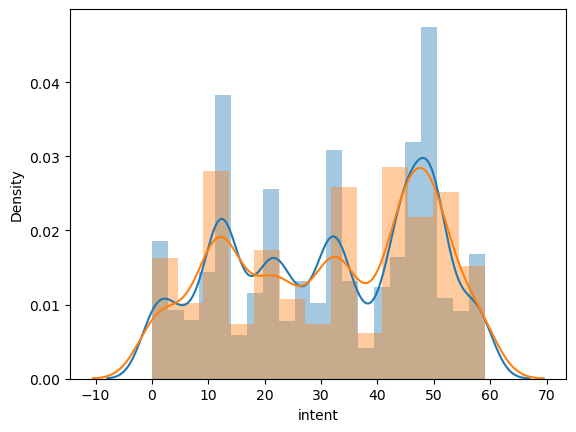

In [22]:
sns.distplot(train['intent'])
sns.distplot(test['intent'])
plt.show()

/tmp/ipykernel_29/2945641427.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['intent'])
/tmp/ipykernel_29/2945641427.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val['intent'])


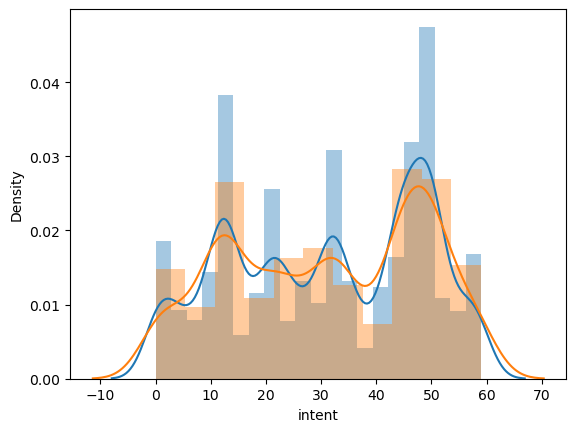

In [23]:
sns.distplot(train['intent'])
sns.distplot(val['intent'])
plt.show()

распределения не сильно разные, поэтому будем работать с тем, что есть

0.000000
25%	15.000000
50%	32.000000
75%	47.000000
max	59.000000Нам не помешает определить максимальную длину предложений

In [24]:
for df in [train, test, val]:
    df['utt'] =  pd.Series(df['utt'], dtype=str)

Количесво классов

In [25]:
classes = train.intent.nunique()

In [26]:
classes

60

In [27]:
info = pd.DataFrame(data={'train': train['utt'].str.len(), 'val': val['utt'].str.len(), 'test': test['utt'].str.len()})

In [28]:
info.describe()

,train,val,test
count,11514.000000,2033.000000,2974.000000
mean,35.038735,34.790457,34.561197
std,16.604056,16.227630,17.204380
min,2.000000,3.000000,2.000000
25%,24.000000,24.000000,23.000000
50%,32.000000,33.000000,32.000000
75%,44.000000,43.000000,43.000000
max,189.000000,153.000000,365.000000


Теперь мы лучше знаем длину предложений, видим, что распределения длин схожи

Остётся решить, какаой длины у нас будет дефолтное предложение, Стоит отметить, что мы рассматрива пока что только длину строк, поэтому финальный результат мы получим только после токенизации

In [29]:
info1 = pd.DataFrame(data={'train': train['utt'].str.split(), 'val': val['utt'].str.split(), 'test': test['utt'].str.split()})

In [30]:
info2=pd.DataFrame(data={'train': train['utt'].str.split().str.len(), 'val': val['utt'].str.split().str.len(), 'test': test['utt'].str.split().str.len()})

In [31]:
info1

,train,val,test
0,"[wake, me, up, at, nine, am, on, friday]","[turn, the, lights, off, please]","[wake, me, up, at, five, am, this, week]"
1,"[set, an, alarm, for, two, hours, from, now]","[dim, the, lights, in, the, hall]",[quiet]
2,"[olly, quiet]","[make, a, room, darker]","[pink, is, all, we, need]"
3,[stop],"[clean, the, flat]","[and, the, darkness, has, fallen]"
4,"[olly, pause, for, ten, seconds]","[cleaning, is, good, dust, is, so, bad, do, no...","[olly, turn, the, lights, off, in, the, bedroom]"
...,...,...,...
11509,"[send, hi, in, watsapp, to, vikki]",NaN,NaN
11510,"[do, i, have, emails]",NaN,NaN
11511,"[what, emails, are, new]",NaN,NaN
11512,"[do, i, have, new, emails, from, john]",NaN,NaN


In [32]:
info1.describe()

,train,val,test
count,11514,2033,2974
unique,11468,2031,2970
top,"[what's, the, time, now]","[what, is, this, week's, weather, forecast]","[i, need, to, get, a, ticket, via, train, to, ..."
freq,2,2,2


In [33]:
info2.describe()

,train,val,test
count,11514.000000,2033.000000,2974.000000
mean,6.924787,6.867683,6.821453
std,3.284967,3.194438,3.392786
min,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000
50%,6.000000,6.000000,6.000000
75%,9.000000,8.000000,8.000000
max,35.000000,27.000000,61.000000


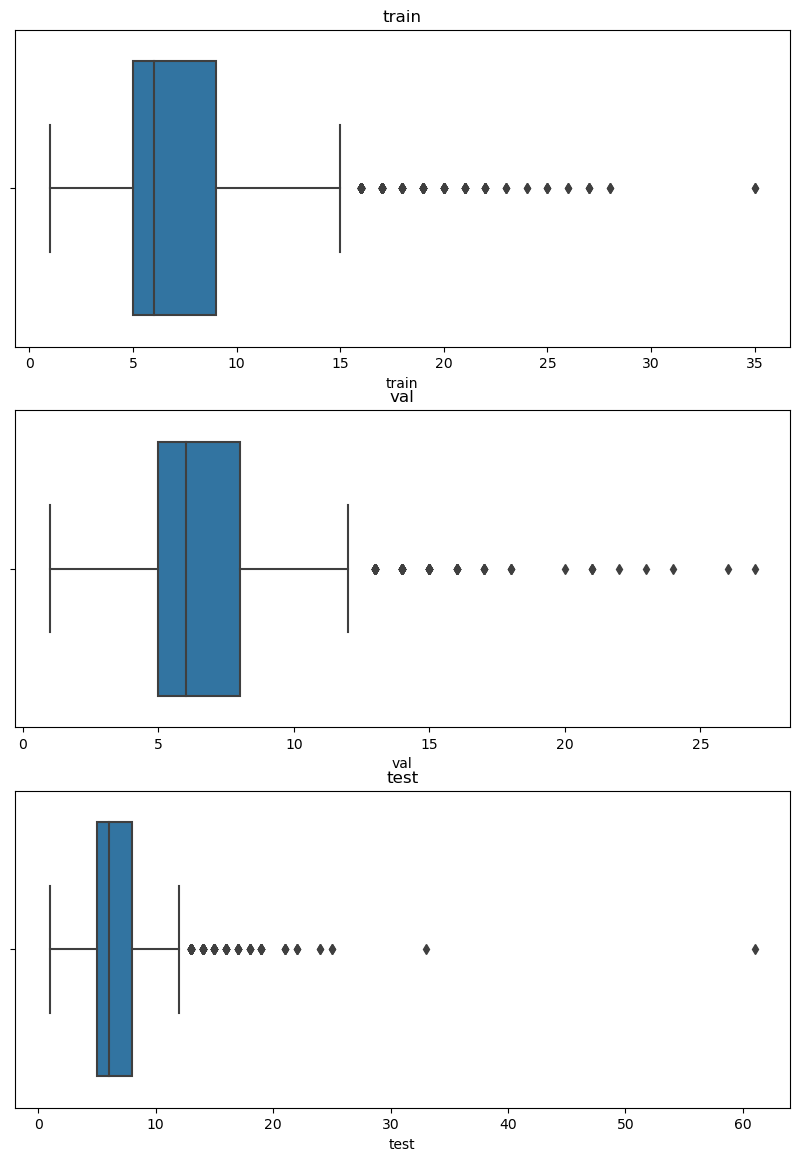

In [34]:
fig, axs = plt.subplots(3,figsize=(10, 14))
for i, df in enumerate(['train', 'val', 'test']):
    sns.boxplot(x=info2[df], ax=axs[i])
    axs[i].set_title(df)
plt.show()

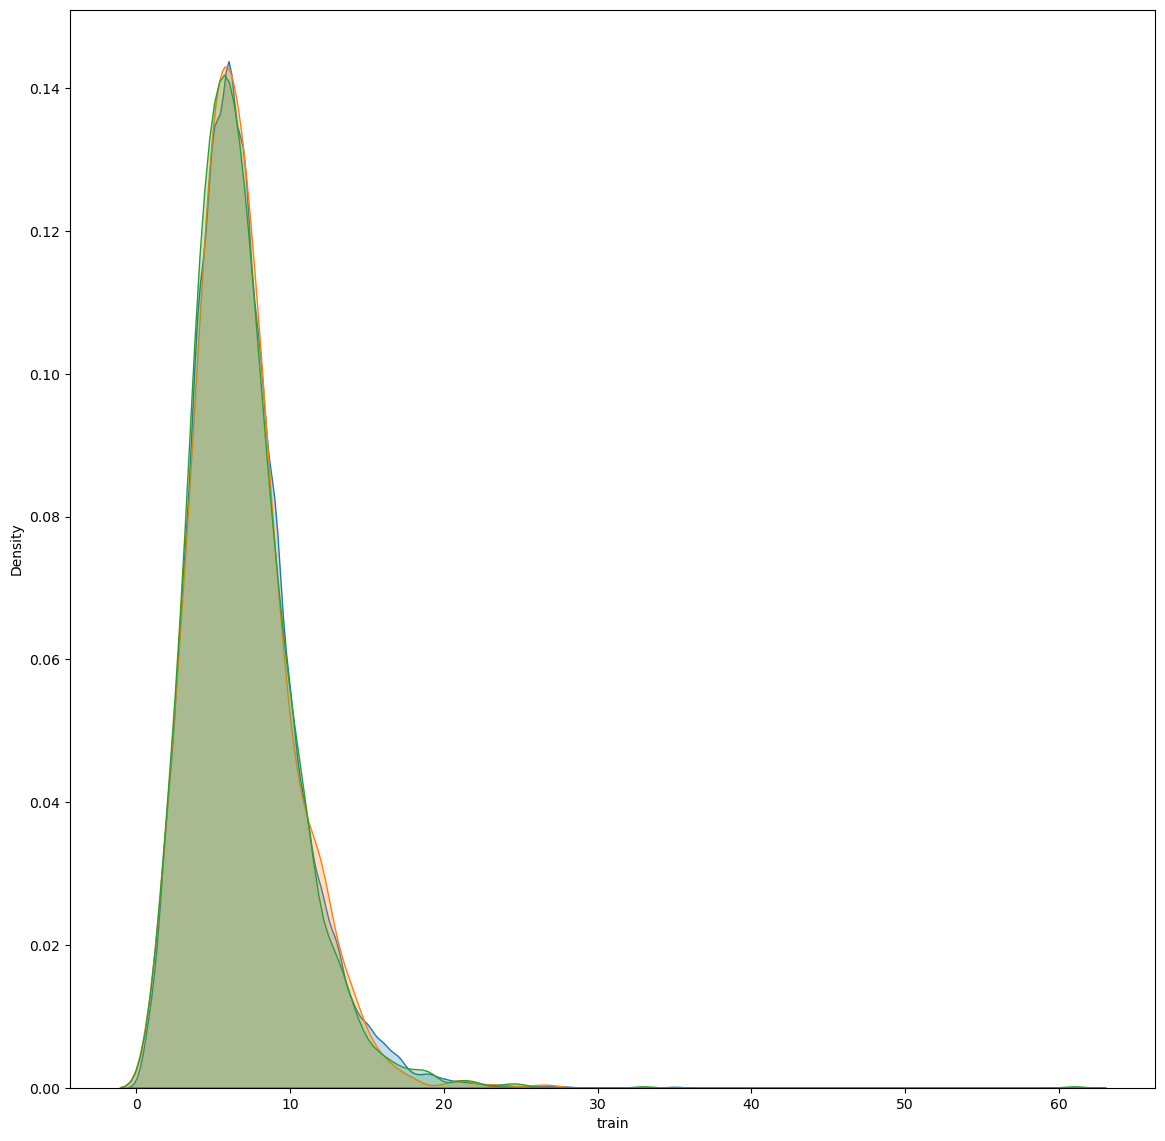

In [35]:
plt.figure(figsize=(14, 14))
for df in ['train', 'val', 'test']:
    sns.kdeplot(data=info2[df], fill=True)
plt.show()

In [36]:
del info, info1, info2

Подготовим датасет для модели

In [37]:
train.utt[67]

"what's this weeks weather"

### Создание даталоадера и обработка текстов

In [38]:
MAX_LEN = 64 # максимальная длина со сплитом по словам 60
BATCH = 32
EPOCHES = 50
LEARNING_RATE = 1e-05

In [39]:
from transformers import BertTokenizer, BertModel

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [41]:
class AmazonDataset(torch.utils.data.Dataset):
  def __init__(self, df, tokenizer, max_len):
    self.df = df
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.target = self.df.intent
    self.text = self.df.utt

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text[index])
    text = " ".join(text.split())
    inputs = self.tokenizer.encode_plus(text,
                                    None,
                                    add_special_tokens=True,
                                    max_length=self.max_len,
                                    padding='max_length',
                                    return_token_type_ids=True,
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors='pt'
                                    )

    return inputs['input_ids'].flatten(), inputs['attention_mask'].flatten(), inputs['token_type_ids'].flatten(), self.target[index]



In [42]:
train_dataset = AmazonDataset(train, tokenizer, MAX_LEN)
valid_dataset = AmazonDataset(val, tokenizer, MAX_LEN)
test_dataset = AmazonDataset(test, tokenizer, MAX_LEN)

In [43]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=BATCH, num_workers=0)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH, num_workers=0)

### написание архитектуры BERT

In [44]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [45]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['oprimizer'])
    val_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], val_loss_min.item()

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    path = checkpoint_path
    torch.save(state, path)
    if is_best:
        best_path = best_model_path
        shutil.copyfile(path, best_path)

In [46]:
class BERT(torch.nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, classes)

    def forward(self, ids, mask, token_type_ids):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1.pooler_output)
        output = self.l3(output_2)
        return F.softmax(output, dim=1)


In [47]:
model = BERT()
model.to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

LOSS

In [48]:
def loss_fn(output, target):
    return F.cross_entropy(output, target)


In [49]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [54]:
def train_model(n_epoches, train_loader, val_loader, model, optimizer, checkpoint_path, best_model_path, loss_fn):
    valid_loss_min = np.inf
    train_loss_arr = np.array([])
    val_loss_arr = np.array([])
    for epoch in tqdm(range(n_epoches)):
        train_loss = 0
        valid_loss = 0
        #train loop
        model.train()
        for i,batch in enumerate(tqdm(train_loader)):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            targets = batch[3].to(DEVICE)

            logits = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            del input_ids, attention_mask, targets, logits
        train_loss_arr = np.append(train_loss_arr, train_loss/len(train_loader))
        
        #vall loop
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(DEVICE)
                attention_mask = batch[1].to(DEVICE)
                token_type_ids = batch[2].to(DEVICE)
                targets = batch[3].to(DEVICE)
                logits = model(input_ids, attention_mask, token_type_ids)

                loss = loss_fn(logits, targets)
                valid_loss += loss.item()
                del input_ids, attention_mask, targets, logits
            val_loss_arr = np.append(val_loss_arr, valid_loss/len(val_loader))
        checkpoint = {
            'epoch':epoch,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint, False, checkpoint_path, best_model_path)
    return train_loss_arr, val_loss_arr, model

In [51]:
# for batch in train_dataloader:
#     input_ids = batch[0].to(DEVICE)
#     attention_mask = batch[1].to(DEVICE)
#     token_type_ids = batch[2].to(DEVICE)
#     targets = batch[3].to(DEVICE)

#     outputs = model(input_ids, attention_mask, token_type_ids)
#     print(targets)
#     print(targets.shape)
#     print(outputs)
#     print(outputs.shape)
#     print(sum(outputs[0].detach().cpu()))
#     print(F.cross_entropy(outputs, targets))
#     del input_ids, attention_mask, token_type_ids, targets, outputs
#     break


In [52]:
! mkdir best currentcurrentcurrent

In [56]:
loss_train, loss_val, trained_model = train_model(EPOCHES, train_dataloader, valid_dataloader, model, optimizer, 'current', 'best', loss_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

### Просмотрим, как обучилась модель за 50 эпох

In [57]:
def plot_loss(train, val):
    plt.plot(train)
    plt.plot(val)
    plt.show()

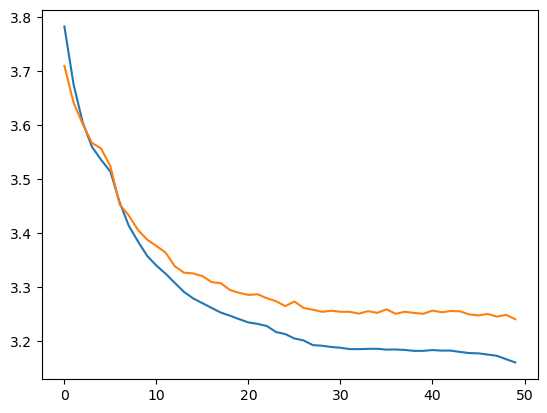

In [58]:
plot_loss(loss_train, loss_val)

после 30 эпохи модель перестала терять лос на валидации, поэтому 30 эпах вполне хватило бы

 ### Оценим модель

In [59]:
def eval_model(model, test_dataloader):
    PREDS = np.array([])
    TARGETS = np.array([])
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            targets = batch[3].to(DEVICE)
            outputs = model(input_ids, attention_mask, token_type_ids)

            outputs = torch.argmax(outputs, dim=1)
            PREDS = np.append(outputs.detach().cpu().numpy(), PREDS)
            TARGETS = np.append(targets.detach().cpu().numpy(), TARGETS)
            del input_ids, attention_mask, targets, outputs
    return TARGETS, PREDS

In [60]:
TARGETS, PREDS = eval_model(trained_model, test_dataloader)

  0%|          | 0/93 [00:00<?, ?it/s]

In [61]:
from sklearn.metrics import f1_score   
f1_score = f1_score(TARGETS, PREDS, average='weighted')

In [62]:
f1_score

0.8824549390105154

In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(TARGETS, PREDS)

0.8846671149966375

Мы получили не самый плохой скор, но скорее всего можно было сделать и лучше, углубить классификатор, который идёт после БЕРТа, добавить scheduler, чтобы лучше управлять шагом градиентного спуска, добавть брейк поинт, когда лосс на валидации перестаёт падать